# Imports

In [338]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from statsmodels.tsa.stattools import adfuller

# Data Collection

In this exploratory data analysis we are going to be looking at the top 5 most played games on steam as of June 2022 which are Lost Ark, Counter-Strike, Dota 2, ARK, and Apex Legends. The data is going to be csv files that were downloaded from https://steamdb.info/graph/ and looking at the concurrent players over the course of the month of June 2022 to present day. 

It is important to consider the limitations and strengths of the data set that we are examining:

Pros:
- Exclusively records players from the Steam platform
- Records updated every 10 minutes
- Includes twitch views as an additional feature

Cons:
- Not all Players are included (i.e other platforms)
- Data limited to current week


In [339]:
# Data Collection

FILE_PATH = '../data/apex.csv'
df = pd.read_csv(FILE_PATH)

# Data Cleaning

- Handling Missing Data
- Incorrect datatypes


In [340]:
df

,DateTime,Players,Players Trend,Twitch Viewers
0,2022-06-03 02:50:00,155808,193599.194444,0
1,2022-06-03 03:00:00,157067,193679.762766,69159
2,2022-06-03 03:10:00,157714,193775.993737,69530
3,2022-06-03 03:20:00,158014,193888.013276,69700
4,2022-06-03 03:30:00,158552,194009.904923,72882
...,...,...,...,...
2012,2022-06-17 02:10:00,123712,161919.976436,45020
2013,2022-06-17 02:20:00,127175,161921.113411,44328
2014,2022-06-17 02:30:00,129576,161927.741097,43811
2015,2022-06-17 02:40:00,132040,161931.218390,44776


We will be handling any missing data. Drop the `Players Trend` column as it is the moving average provided by the Steamdb we will be creating our own player trend later on.

In [341]:
# Remove rows where there is no values for players
df.dropna(subset='Players', inplace=True)

# Removing flags column
df.drop(columns=['Players Trend'], inplace=True)

# Rename column names for convinence for later on when doing manipulations with dataframes.
df.columns = ['date', 'players', 'twitch_viewers']

df

,date,players,twitch_viewers
0,2022-06-03 02:50:00,155808,0
1,2022-06-03 03:00:00,157067,69159
2,2022-06-03 03:10:00,157714,69530
3,2022-06-03 03:20:00,158014,69700
4,2022-06-03 03:30:00,158552,72882
...,...,...,...
2012,2022-06-17 02:10:00,123712,45020
2013,2022-06-17 02:20:00,127175,44328
2014,2022-06-17 02:30:00,129576,43811
2015,2022-06-17 02:40:00,132040,44776


Lets make sure that our columns have the correct datatypes. We can see that our date column is of type object indicating its being detected as a string when we really want it as a datetime.

In [342]:
# Checking to make sure that the dataframe has all the correct data types
df.dtypes

date              object
players            int64
twitch_viewers     int64
dtype: object

In [343]:
# Converting to first column to datateime
df.date = pd.to_datetime(df.date)

In [344]:
# Checkign to see that the date column is indeed a datetime rather than object
df.dtypes

date              datetime64[ns]
players                    int64
twitch_viewers             int64
dtype: object

In [345]:
# Check to make sure that the time interval is consistant

df['date_interval'] = df.date - df.shift(1).date

df.date_interval.unique()

array([       'NaT', 600000000000], dtype='timedelta64[ns]')

# Data Exploration
- Summary Statistics
- Correlation Matrix

In [346]:
# Summary statistics of players (Peak # of Players, Lowest # of players, Average # of players)
df.players.describe()

count      2017.000000
mean     179338.286068
std       62722.241271
min       35211.000000
25%      132960.000000
50%      161490.000000
75%      218253.000000
max      344751.000000
Name: players, dtype: float64

Text(0.5, 1.0, '# of Players')

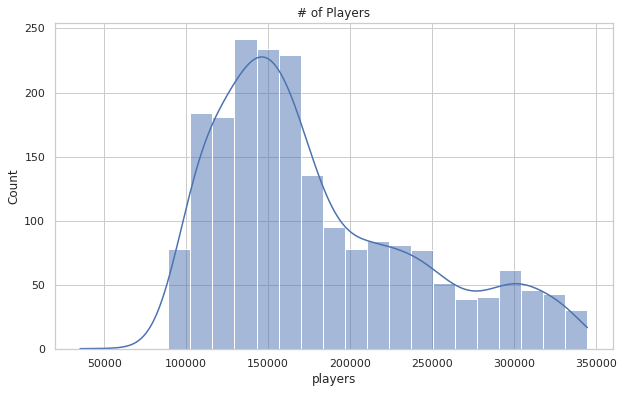

In [347]:
fig = sns.histplot(data=df.players, kde=True)
fig.set_title("# of Players")

In [348]:
# When was the largest decrease or increase of players
df['change_in_players'] = df.players - df.shift(1).players

# Making sure that change in players is an int and not a float
df.dropna(inplace=True)
df.change_in_players = df.change_in_players.astype(int)
df.change_in_players

1       1259
2        647
3        300
4        538
5         47
        ... 
2012    3146
2013    3463
2014    2401
2015    2464
2016     766
Name: change_in_players, Length: 2016, dtype: int64

In [349]:
df.change_in_players.describe()


count     2016.000000
mean       -11.409722
std       4925.495331
min     -62735.000000
25%      -2110.000000
50%        281.000000
75%       2263.250000
max      37091.000000
Name: change_in_players, dtype: float64

Text(0.5, 1.0, 'Frequency Plot of Change in Players')

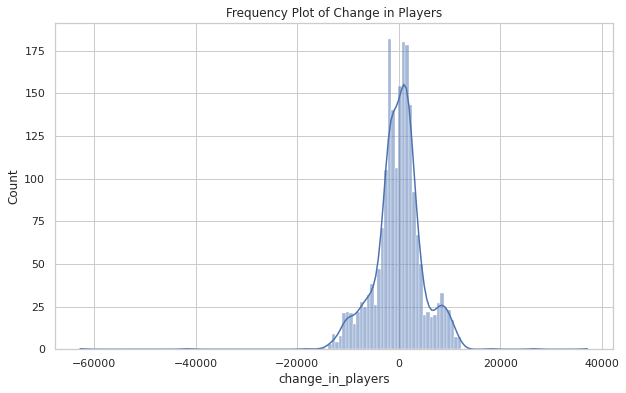

In [350]:
fig = sns.histplot(data=df.change_in_players, kde=True)
fig.set_title("Frequency Plot of Change in Players")


Text(0.5, 1.0, 'Correlation Matrix of Features')

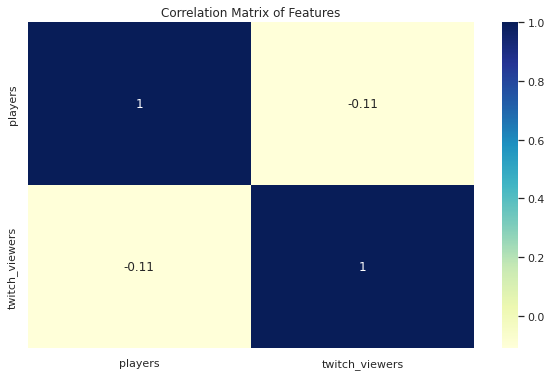

In [351]:
fig = sns.heatmap(df.iloc[:,:3].corr(), annot=True, cmap="YlGnBu")
fig.set_title("Correlation Matrix of Features")

There does not seem to be a correlation between players and twitch viewers and if there is it is a fairly weak correlation of 0.012.

In [352]:
# Simple Moving Average and variance

# Period is 1 week since there are 10 minute intervals between each data point and 24 hours in a day and 7 days in a week
PERIOD = 24*6*7

df['sma'] = df.players.rolling(window=PERIOD).mean()
df['std'] = df.players.rolling(window=PERIOD).var()
df

,date,players,twitch_viewers,date_interval,change_in_players,sma,std
1,2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN
2,2022-06-03 03:10:00,157714,69530,0 days 00:10:00,647,NaN,NaN
3,2022-06-03 03:20:00,158014,69700,0 days 00:10:00,300,NaN,NaN
4,2022-06-03 03:30:00,158552,72882,0 days 00:10:00,538,NaN,NaN
5,2022-06-03 03:40:00,158599,70630,0 days 00:10:00,47,NaN,NaN
...,...,...,...,...,...,...,...
2012,2022-06-17 02:10:00,123712,45020,0 days 00:10:00,3146,173694.795635,3.747205e+09
2013,2022-06-17 02:20:00,127175,44328,0 days 00:10:00,3463,173688.967262,3.747713e+09
2014,2022-06-17 02:30:00,129576,43811,0 days 00:10:00,2401,173682.773810,3.748221e+09
2015,2022-06-17 02:40:00,132040,44776,0 days 00:10:00,2464,173676.510913,3.748704e+09


(19144.0, 19156.0)

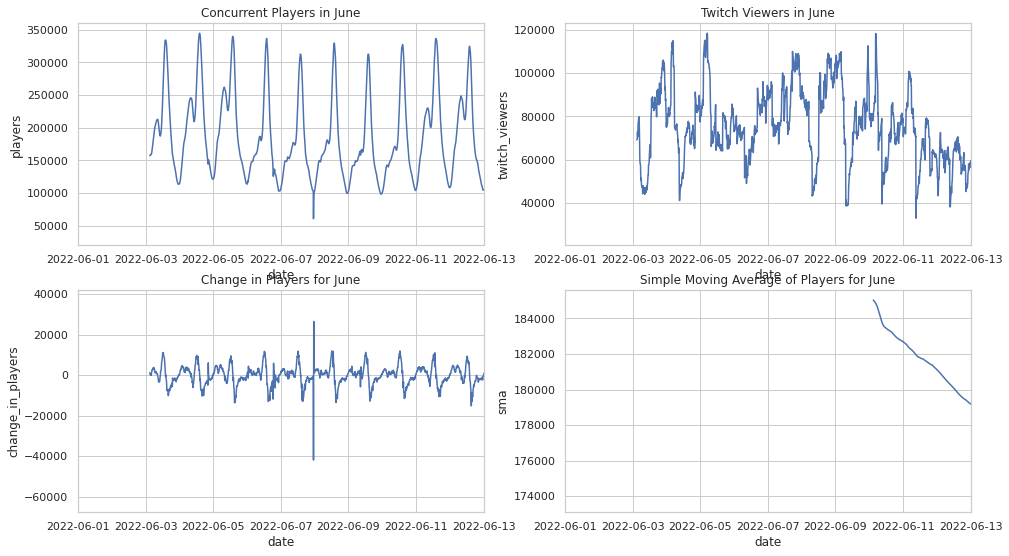

In [353]:
# Ploting


f, ax = plt.subplots(2,2,figsize=(16,9))

# Plotting columns
sns.lineplot(x=df.date, y=df.players, ax=ax[0,0])
sns.lineplot(x=df.date, y=df.twitch_viewers, ax=ax[0,1])
sns.lineplot(x=df.date, y=df.change_in_players, ax=ax[1,0])
sns.lineplot(x=df.date, y=df.sma, ax=ax[1,1])

ax[0,0].set_title("Concurrent Players in June")
ax[0,1].set_title("Twitch Viewers in June")
ax[1,0].set_title("Change in Players for June")
ax[1,1].set_title("Simple Moving Average of Players for June")

# Setting the x label axis to dates
ax[0,0].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])
ax[0,1].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])
ax[1,0].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])
ax[1,1].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])


Question: Which days does the # of players peak?

We can approach this by labeling the dates to its corresponding day of the week (monday, tuesday, wednesday, thursday, friday) and display it as a `violin plot` that way we can get a glimpse of the distribution as well.


In [354]:

# Labeling which dates corresponds to which day of the week.
df['day'] = df.date.dt.day_name()
df.day = df.day.apply(lambda x: x[:3])

The answer to which day has the highest number of players actively playing is `saturday`. The advantage violinplots is that it also provides some visual representation of the distribution for each day unlike a box and whiskers plot.

Text(0.5, 1.0, 'Distribution of Players per Day')

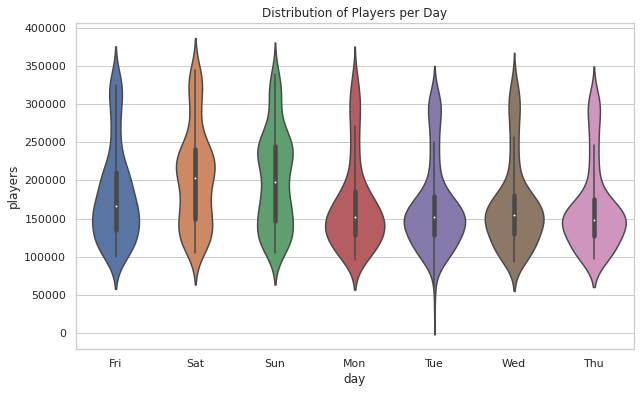

In [355]:
fig = sns.violinplot(x=df.day, y=df.players, data=df)
fig.set_title("Distribution of Players per Day")

We can also ask a similar question of which hours do people mostly play. This might be useful information to do an in game promotion when most players are online.

In [356]:
# Labeling which dates corresponds to the hour.
df['hour'] = df.date.dt.hour
df

,date,players,twitch_viewers,date_interval,change_in_players,sma,std,day,hour
1,2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN,Fri,3
2,2022-06-03 03:10:00,157714,69530,0 days 00:10:00,647,NaN,NaN,Fri,3
3,2022-06-03 03:20:00,158014,69700,0 days 00:10:00,300,NaN,NaN,Fri,3
4,2022-06-03 03:30:00,158552,72882,0 days 00:10:00,538,NaN,NaN,Fri,3
5,2022-06-03 03:40:00,158599,70630,0 days 00:10:00,47,NaN,NaN,Fri,3
...,...,...,...,...,...,...,...,...,...
2012,2022-06-17 02:10:00,123712,45020,0 days 00:10:00,3146,173694.795635,3.747205e+09,Fri,2
2013,2022-06-17 02:20:00,127175,44328,0 days 00:10:00,3463,173688.967262,3.747713e+09,Fri,2
2014,2022-06-17 02:30:00,129576,43811,0 days 00:10:00,2401,173682.773810,3.748221e+09,Fri,2
2015,2022-06-17 02:40:00,132040,44776,0 days 00:10:00,2464,173676.510913,3.748704e+09,Fri,2


Plotting a lineplot of the military time in the x-axis and the # of players on the y-axis we can see from the plot below that saturday peaks the highest and also theres an interesting initial peak before most players play at `2:00 PM`.

Text(0.5, 1.0, '# of Players at a given Time Grouped by Day')

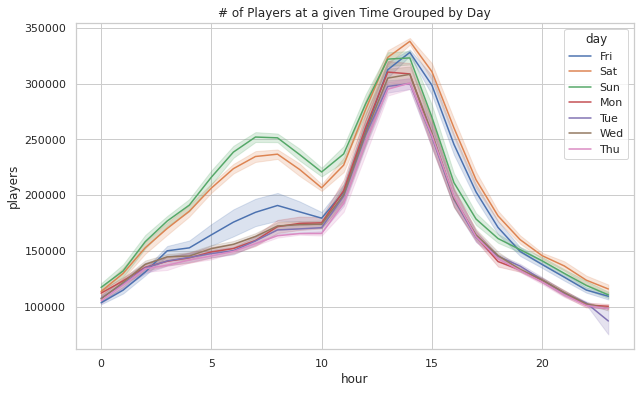

In [357]:
fig = sns.lineplot(x=df.hour, y=df.players, hue=df.day)
fig.set_title("# of Players at a given Time Grouped by Day")

We can also look at the distribution for changes in player count throughout each day. We find that it is pretty much similar for each day except one thing to notice is that Tuesday seems abnormal which may for various reasons maybe servers went down that day for maintaince. Further exploration would be needed to pinpoint why exactly there is some outliers present for Tuesday.

Text(0.5, 1.0, 'Change in Players per Day')

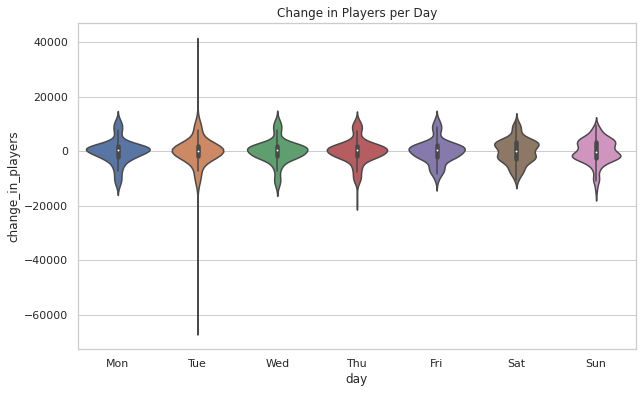

In [366]:
fig = sns.violinplot(x=df.day, y=df.change_in_players, data=df, order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
fig.set_title("Change in Players per Day")

There are certain characteristics that we can check if our time series satisfy:

- Seasonality
- Trend
- Stationary

Along with these characteristics we can compute various averages:

- Simple Moving Average
- Exponential Moving Average

Text(0.5, 1.0, '# of Players with Simple Moving Average')

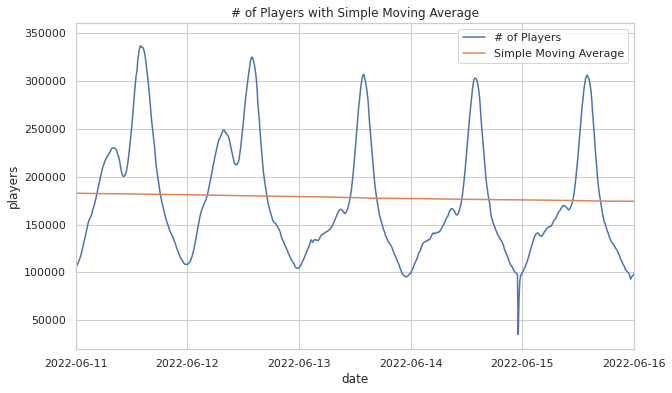

In [359]:
# Simple Moving Average

sns.set_style("whitegrid")
fig = sns.lineplot(x=df.date, y=df.players, label="# of Players")
sns.lineplot(x=df.date, y=df.sma, label="Simple Moving Average")
fig.set_xlim([date(2022, 6, 11), date(2022, 6, 16)])
fig.set_title("# of Players with Simple Moving Average")

Text(0.5, 1.0, '# of Players with Exponential Moving Average')

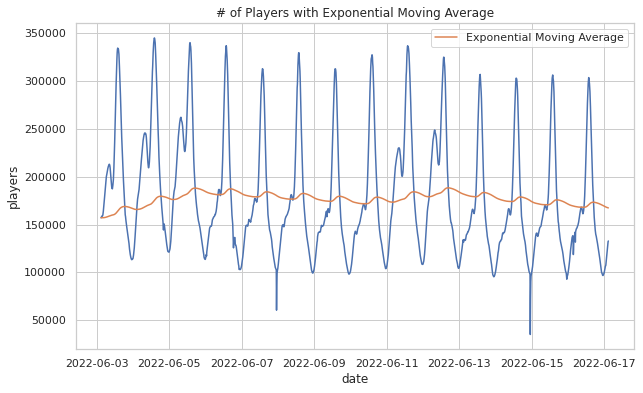

In [360]:
# Exponential Moving Average

fig = sns.lineplot(x=df.date, y=df.players)
sns.lineplot(x=df.date, y=df.players.ewm(span=PERIOD, adjust=False).mean(), label="Exponential Moving Average")
fig.set_title("# of Players with Exponential Moving Average")

Naive Decomposition of the time series to visualize the trend, seasonality and residuals.

Observed = Trend + Seasonality + Residuals

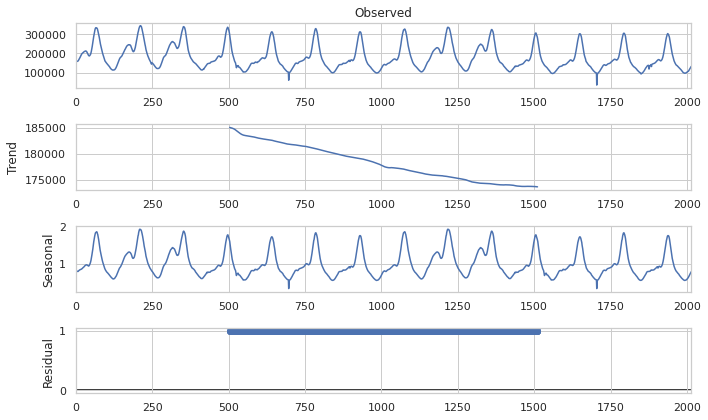

In [361]:
# Naive Decomposition
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(x=df.players.values, period=PERIOD, model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

Conducting Dicky-Fuller test since we want to know if the time series is stationary aka constant mean and variance. The null hypothesis of this test is that the time series is non-stationary. So we need our p-value to be less than 0.05 in order to reject our null hypthesis. As we can see from below the p-value is less than 0.05 so we can indeed reject our null hypothesis that it is non-stationary and say that our data does have stationary mean and variance.

In [362]:
test_statistic, p_value, *_ = adfuller(df.players)

print(f"Test Statistic: {test_statistic}")
print(f"p-value: {p_value}")


Test Statistic: -7.433941313267819
p-value: 6.254742639140234e-11


Saving the dataframe that we have created through data exploratory analysis so that we can move on to modeling

In [368]:
df.to_pickle(path="../data/apex")